# Macro research
## Quantifying geopolitical uncertainty that isn’t yet reflected in the markets


### Introduction

-  The world is currently experiencing more conflicts than at any time since the post-9/11 Iraq war.
-  I believe the risk of nuclear war is at its highest level since the Cold War.
-  Despite these risks, the S&P 500 keeps reaching new highs, driven by the ChatGPT initiated tech boom.
-  Markets seem aware of war risks, as shown by Bitcoin's quick drop when Iran attacked Israel with war drones. S&P 500 did not reflect this drop as it was a Sunday.
-  This leads me to believe that that markets believe AI's economic benefits outweigh the potential negative impacts of war.
-  This study aims to:
  1. Measure the positive effects of AI and negative effects of war on the economy
  2. Analyze how these 2 factors are currently priced into markets
  3. Compare the current situations with the 2000 tech boom and Cold War era to identify possible future scenarios.

### Hypotheses

1. **AI's Economic Impact vs. War Risks**  
   Hypothesis: The S&P 500 and other global indices are more influenced by AI-driven growth trends than by geopolitical risks such as conflicts or war.

   - Test: Analyze correlations between AI-driven tech indices (e.g., NASDAQ Composite or specific AI-related ETFs) and macroeconomic indicators (e.g., GDP, unemployment). Compare these correlations during different periods of conflict.

2. **Bitcoin as a Geopolitical Risk Barometer**  
   Hypothesis: Bitcoin responds more rapidly to geopolitical tensions compared to traditional equity indices due to its decentralized nature.

   - Test: Analyze intraday price movements of Bitcoin and compare them to the S&P 500 during major geopolitical events, such as the Iran-Israel drone attack.

3. **Market Resilience During Conflict**  
   Hypothesis: The current resilience of the S&P 500 to geopolitical shocks is comparable to market behavior during the Cold War and the 2000 Tech Boom, suggesting that technological optimism outweighs geopolitical fears.

   - Test: Compare volatility indices (e.g., VIX) and treasury yields during key geopolitical tensions across the Cold War, 2000 Tech Boom, and post-2022 AI boom.

4. **Geopolitical Risk Premium in Fixed Income**  
   Hypothesis: Treasury yields reflect a greater sensitivity to geopolitical risks compared to equity indices, acting as a haven during periods of heightened tensions.

   - Test: Compare movements in 10-year and 30-year Treasury yields during major geopolitical events with equity indices' performance.

5. **Liquidity Indicators and War Risks**  
   Hypothesis: Increased liquidity injections by central banks during geopolitical crises stabilize markets, reducing immediate impacts of conflict-related news.

   - Test: Compare changes in the Federal Reserve Balance Sheet (WALCL) and Overnight Reverse Repo Agreements (RRPONTSYD) during major conflicts.

### Methodology

1. **Time Period Analysis**  
   Segment the dataset into the predefined periods:  
   - Post-2022 AI Tech Boom  
   - Cold War  
   - 2000 Tech Boom  

   Use these periods to analyze how macroeconomic indicators, equity indices, and fixed-income instruments responded to technological trends and geopolitical risks.

2. **Volatility and Sensitivity Analysis**  
   - Use historical daily returns for indices (`df_yahoo_returns`) to calculate rolling volatilities during conflict periods.  
   - Apply event studies to assess market reactions to major geopolitical events.

3. **Regression Analysis**  
   - Use equity returns (e.g., S&P 500) as the dependent variable and macro indicators (e.g., treasury spreads, inflation, GDP) as independent variables.  
   - Add dummy variables for conflict events to measure their incremental impact.

4. **Scenario Comparisons**  
   - Compare Sharpe ratios, volatility, and drawdowns for indices across the three periods.  
   - Evaluate how liquidity measures and stress indices (e.g., STLFSI) varied during high-conflict periods.

5. **Correlation Analysis**  
   - Assess correlations between Bitcoin and equity indices during geopolitical events.  
   - Compare correlations of growth indicators (e.g., GDP) with equity indices across periods.

6. **Visualizations**  
   - Plot historical returns with time-period-specific shading using `time_period_colors` for intuitive comparison.  
   - Overlay macroeconomic indicators like treasury yields, volatility (VIX), and Bitcoin prices on the same timeline.

### Need to add implied vol options data predicions on spy for forecasts

### DOWNLOAD DATA

In [1]:
import pandas as pd
from yahooquery import Ticker
from fredapi import Fred
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

# Initialize Yahoo Finance and FRED tickers
yahoo_tickers = {
    # Equity Indices
    "^GSPC": "S&P 500",
    "^N225": "Nikkei 225",
    "^FTSE": "FTSE 100",
    "^HSI": "Hang Seng Index",
    "^IXIC": "NASDAQ Composite",

    # Fixed Income
    "^TNX": "10-Year Treasury Yield",
    "^TYX": "30-Year Treasury Yield",
    "^FVX": "5-Year Treasury Yield",
    "^IRX": "13-Week Treasury Bill Yield",

    # Volatility
    "^VIX": "CBOE Volatility Index",

    # Crypto
    "BTC-USD": "Bitcoin_USD",
}

fred_series = {
    # Growth and Employment
    'GDP': 'Gross Domestic Product',
    'UNRATE': 'Unemployment Rate',
    'INDPRO': 'Industrial Production',
    'PAYEMS': 'Nonfarm Payrolls',
    'CIVPART': 'Labor Force Participation Rate',

    # Inflation and Prices
    'CPIAUCSL': 'Consumer Price Index',
    'PPIACO': 'Producer Price Index',
    'PCEPILFE': 'Core PCE Price Index',

    # Trade and Globalization
    'BOPGSTB': 'Trade Balance',
    'DTWEXBGS': 'US Dollar Index',

    # Financial Conditions
    'FEDFUNDS': 'Federal Funds Rate',
    'T10Y2Y': '10-Year Treasury Minus 2-Year Treasury Spread',
    'BAA10Y': 'Moody’s BAA Corporate Bond Yield Spread',
    'STLFSI': 'St. Louis Fed Financial Stress Index',
    
    # Liquidity Indicators
    'WALCL': 'Federal Reserve Balance Sheet',
    'M1SL': 'M1 Money Stock',  # NARROW
    'M2SL': 'M2 Money Stock',
    'RRPONTSYD': 'Overnight Reverse Repo Agreements',
    'TOTALSL': 'Total Assets, Liquidity Facilities',
    'DFF': 'Effective Federal Funds Rate'
}

# Initialize data containers
yahoo_data = {}
fred_data = {}

# Fetch data from Yahoo Finance
for ticker, name in yahoo_tickers.items():
    try:
        data = Ticker(ticker)
        history = data.history(period="max")
        if not history.empty:  # Ensure data exists for the ticker
            history['Ticker'] = ticker
            history['Name'] = name
            yahoo_data[ticker] = history
            print(f"Fetched data for {name} ({ticker})")
        else:
            print(f"No data for {name} ({ticker})")
            
    except Exception as e:
        print(f"Error fetching data for {name} ({ticker}): {e}")

# Fetch data from FRED API (ensure you replace the API key with your own)
fred_api_key = os.getenv('FRED_API_KEY')  # Replace with your FRED API key or set it as an environment variable
fred = Fred(api_key=fred_api_key)

for series_id, series_name in fred_series.items():
    try:
        series_data = fred.get_series(series_id)
        if series_data is not None and not series_data.empty:  # Ensure data exists for the series
            series_df = pd.DataFrame(series_data, columns=['Value'])
            series_df['Ticker'] = series_id
            series_df['Name'] = series_name
            fred_data[series_id] = series_df
            print(f"Fetched data for {series_name} ({series_id})")
        else:
            print(f"No data for {series_name} ({series_id})")
            
    except Exception as e:
        print(f"Error fetching data for {series_name} ({series_id}): {e}")

# Define time periods and their corresponding colors
time_periods = {
    "Post-2022 AI Tech Boom": ("2022-01-01", "2025-01-01"),
    "Cold War": ("1947-01-01", "1991-12-31"),
    "2000 Tech Boom": ("1995-01-01", "2002-12-31")
}
time_period_colors = {
    "Post-2022 AI Tech Boom": "lightblue",
    "Cold War": "lightgreen",
    "2000 Tech Boom": "lightcoral"
}

# Combine Yahoo Finance data into a single DataFrame and save to CSV
if yahoo_data:
    df_yahoo = pd.concat(yahoo_data.values(), ignore_index=False)
    df_yahoo.reset_index(inplace=True)
    df_yahoo.to_csv('yahoo_data.csv', index=False)
else:
    print("No Yahoo Finance data to save.")

# Combine FRED data into a single DataFrame and save to CSV
if fred_data:
    df_fred = pd.concat(fred_data.values(), ignore_index=False)
    df_fred.reset_index(inplace=True)
    df_fred.rename(columns={"index":"date"}, inplace=True)
    df_fred.to_csv('fred_data.csv', index=False)
else:
    print("No FRED data to save.")

# Set 'date' as index for easier manipulation
df_yahoo.set_index('date', inplace=True)
df_fred.set_index('date', inplace=True)

# Calculate daily returns for each ticker in df_yahoo (using 'adjclose' column)
tickers_yahoo = df_yahoo['Ticker'].unique()
tickers_fred = df_fred['Ticker'].unique()

# Exclude fixed-income yield tickers for returns calculations
exclude_tickers = ['^TNX', '^TYX', "^FVX", "^IRX"]  # Exclude Treasury yields from returns calculations

# Initialize an empty DataFrame for returns
df_yahoo_returns = pd.DataFrame()

# Loop through tickers_yahoo (the list of tickers you want to process)
for ticker in tickers_yahoo:
    if ticker not in exclude_tickers:  # Only include tickers that are not in the exclude list
        # Filter the dataframe for the current ticker
        ticker_data = df_yahoo[df_yahoo['symbol'] == ticker]
        
        # Calculate percentage change for adjusted close prices and drop NaNs
        df_yahoo_returns[ticker] = ticker_data['adjclose'].pct_change().dropna()

def date_filter(df, start_date, end_date):
    """
    Filter a DataFrame by the given date range.
    Assumes the index is a datetime index.
    """
    return df[(df.index >= start_date) & (df.index <= end_date)]


def ensure_datetime_index(df):
    """
    Ensure the index is a timezone-naive datetime index.
    If the index is timezone-aware, convert to naive (UTC).
    If it's naive, just ensure it's a correct datetime format.
    
    Args:
        df (pd.DataFrame): The DataFrame whose index is to be checked and potentially converted.

    Returns:
        pd.DataFrame: The DataFrame with a timezone-naive datetime index.
    
    Raises:
        TypeError: If the index of the DataFrame is not a pd.DatetimeIndex or cannot be converted to a datetime.
    """
    if not isinstance(df.index, pd.Index):
        raise TypeError(f"Index must be a pandas Index. Found: {type(df.index)}")

    if isinstance(df.index, pd.DatetimeIndex):
        if df.index.tz is not None:
            print("Timezone-aware datetime detected. Converting to naive datetime (UTC).")
            df.index = df.index.tz_convert('UTC').tz_localize(None)
        else:
            print("Timezone-naive datetime detected.")
    else:
        print("Index is not a datetime type. Attempting to convert to datetime.")
        try:
            df.index = pd.to_datetime(df.index, utc=True).tz_localize(None)
        except ValueError as e:
            print(f"Error converting index to datetime: {e}")
            print("Attempting to convert with 'coerce' option...")
            df.index = pd.to_datetime(df.index, errors='coerce', utc=True).tz_localize(None)

    if df.index.hasnans:
        print("Warning: Index contains NaT values after conversion.")
        
    return df

# Apply the data cleaning functions to your DataFrames
df_fred = ensure_datetime_index(df_fred)
df_yahoo = ensure_datetime_index(df_yahoo)
df_yahoo_returns = ensure_datetime_index(df_yahoo_returns)

df_fred.dropna(inplace=True)

Fetched data for S&P 500 (^GSPC)
Fetched data for Nikkei 225 (^N225)
Fetched data for FTSE 100 (^FTSE)
Fetched data for Hang Seng Index (^HSI)
Fetched data for NASDAQ Composite (^IXIC)
Fetched data for 10-Year Treasury Yield (^TNX)
Fetched data for 30-Year Treasury Yield (^TYX)
Fetched data for 5-Year Treasury Yield (^FVX)
Fetched data for 13-Week Treasury Bill Yield (^IRX)
Fetched data for CBOE Volatility Index (^VIX)
Fetched data for Bitcoin_USD (BTC-USD)
Fetched data for Gross Domestic Product (GDP)
Fetched data for Unemployment Rate (UNRATE)
Fetched data for Industrial Production (INDPRO)
Fetched data for Nonfarm Payrolls (PAYEMS)
Fetched data for Labor Force Participation Rate (CIVPART)
Fetched data for Consumer Price Index (CPIAUCSL)
Fetched data for Producer Price Index (PPIACO)
Fetched data for Core PCE Price Index (PCEPILFE)
Fetched data for Trade Balance (BOPGSTB)
Fetched data for US Dollar Index (DTWEXBGS)
Fetched data for Federal Funds Rate (FEDFUNDS)
Fetched data for 10-Ye

Event date 2023-10-01 00:00:00 not found. Using closest available date: 2023-10-02 00:00:00
Event date 2023-10-01 00:00:00 not found. Using closest available date: 2023-10-02 00:00:00
Bitcoin Change after event: -237.12244866337443%
S&P 500 Change after event: 13137.146347912394%


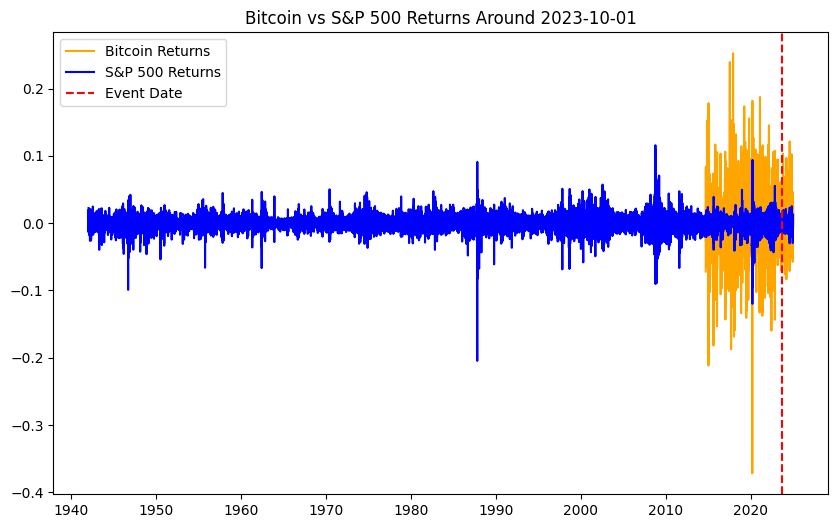

Regression Coefficients: [0.02207466 0.17430309]
Intercept: 1.0911231926352381e-17


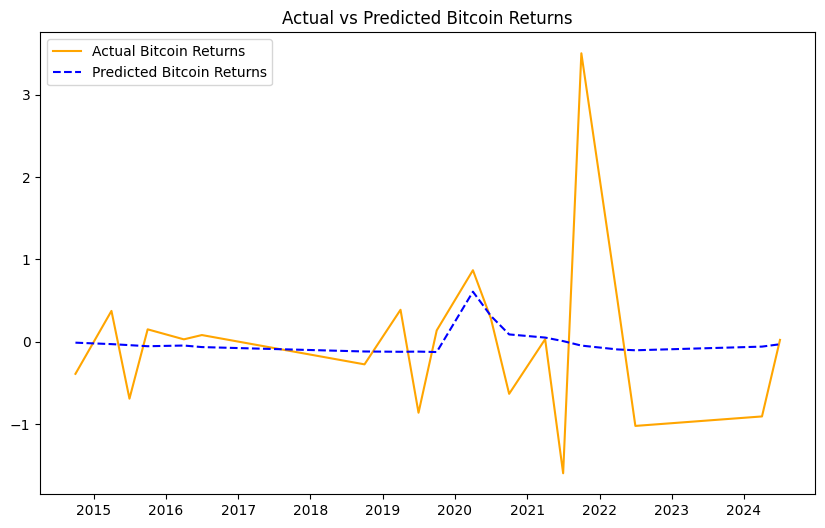

In [2]:

# Define event-driven analysis function
def event_driven_change(event_date, df, column_name, days=30):
    """
    Calculate the percentage change in a specified column after a given event date.
    """
    # Ensure the column exists in the DataFrame
    if column_name not in df.columns:
        raise ValueError(f"Column {column_name} does not exist in the DataFrame.")
    
    # Check if the event_date is in the dataframe
    if event_date not in df.index:
        # Find the closest available date (nearest)
        timedeltas = df.index - event_date
        closest_date = df.index[(np.abs(timedeltas)).argmin()]
        print(f"Event date {event_date} not found. Using closest available date: {closest_date}")
        event_date = closest_date
    
    # Get the value on the event date for the selected column
    value_on_event_date = df.loc[event_date, column_name]
    
    # Calculate the end date (30 days later)
    end_date = event_date + pd.Timedelta(days=days)
    
    # Check if end_date exists in the DataFrame, if not, use the closest available date
    if end_date not in df.index:
        # Find the closest available end_date (bfill)
        timedeltas = df.index - end_date
        end_date = df.index[(np.abs(timedeltas)).argmin()]
        print(f"End date {end_date} not found. Using closest available date.")
    
    # Get the value 30 days after the event date
    value_30_days_after = df.loc[end_date, column_name]
    
    # Calculate the percentage change
    percentage_change = (value_30_days_after - value_on_event_date) / value_on_event_date * 100
    
    return percentage_change

# Example: Test event-driven changes for Bitcoin and S&P 500 during an event (e.g., geopolitical risk event)
event_date = pd.Timestamp('2023-10-01')
btc_change = event_driven_change(event_date, df_yahoo_returns, 'BTC-USD')
sp500_change = event_driven_change(event_date, df_yahoo_returns, '^GSPC')

print(f"Bitcoin Change after event: {btc_change}%")
print(f"S&P 500 Change after event: {sp500_change}%")

# Visualize the event-driven analysis (Bitcoin vs S&P 500)
plt.figure(figsize=(10,6))
plt.plot(df_yahoo_returns.index, df_yahoo_returns['BTC-USD'], label='Bitcoin Returns', color='orange')
plt.plot(df_yahoo_returns.index, df_yahoo_returns['^GSPC'], label='S&P 500 Returns', color='blue')
plt.axvline(x=event_date, color='red', linestyle='--', label='Event Date')
plt.title(f"Bitcoin vs S&P 500 Returns Around {event_date.strftime('%Y-%m-%d')}")
plt.legend()
plt.show()

# Extract relevant FRED variables (GDP and Unemployment Rate)
gdp_data = df_fred[df_fred['Ticker'] == 'GDP'][['Value']].rename(columns={'Value': 'GDP'})
unemployment_data = df_fred[df_fred['Ticker'] == 'UNRATE'][['Value']].rename(columns={'Value': 'Unemployment Rate'})

# Merge the dataframes: Yahoo returns and FRED data
df_combined = pd.concat([df_yahoo_returns['BTC-USD'], gdp_data, unemployment_data], axis=1).dropna()

# Standardize the data (important for regression)
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_combined), columns=df_combined.columns, index=df_combined.index)

# Linear Regression Model
X = df_scaled[['GDP', 'Unemployment Rate']]  # Independent variables (predictors)
y = df_scaled['BTC-USD']  # Dependent variable (target)

# Create and fit the regression model
model = LinearRegression()
model.fit(X, y)

# Output coefficients and intercept
print(f"Regression Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_}")

# Predict Bitcoin returns using the model
df_scaled['Predicted BTC-USD'] = model.predict(X)

# Plot the actual vs predicted Bitcoin returns
plt.figure(figsize=(10, 6))
plt.plot(df_scaled.index, df_scaled['BTC-USD'], label='Actual Bitcoin Returns', color='orange')
plt.plot(df_scaled.index, df_scaled['Predicted BTC-USD'], label='Predicted Bitcoin Returns', color='blue', linestyle='--')
plt.legend()
plt.title('Actual vs Predicted Bitcoin Returns')
plt.show()


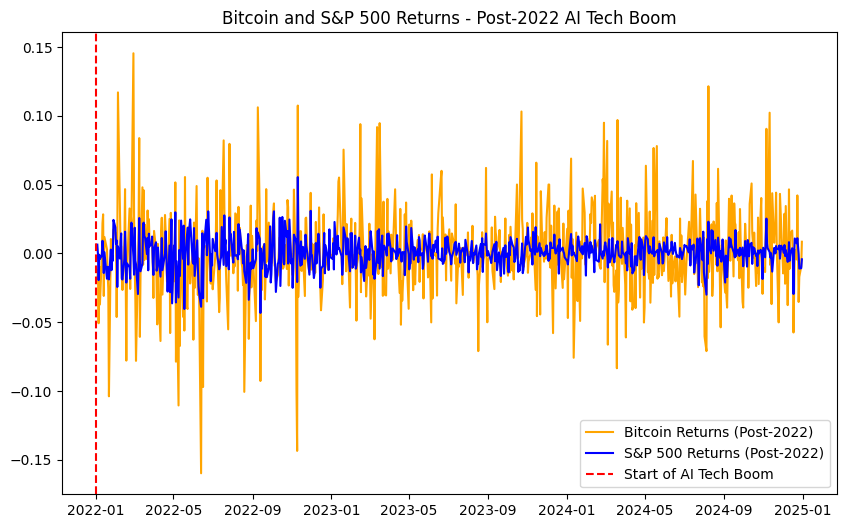

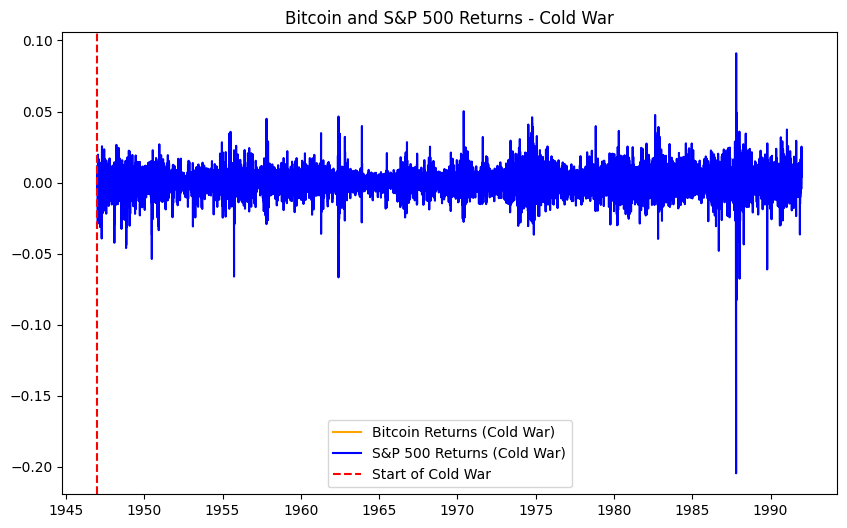

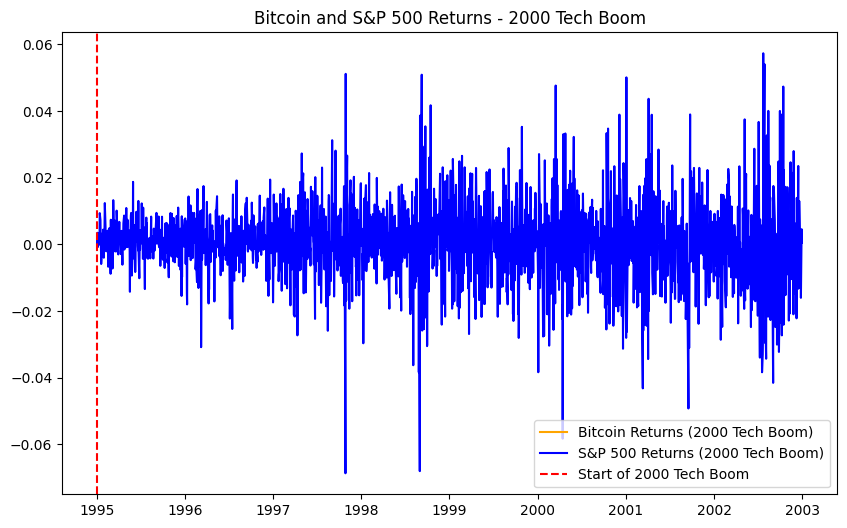

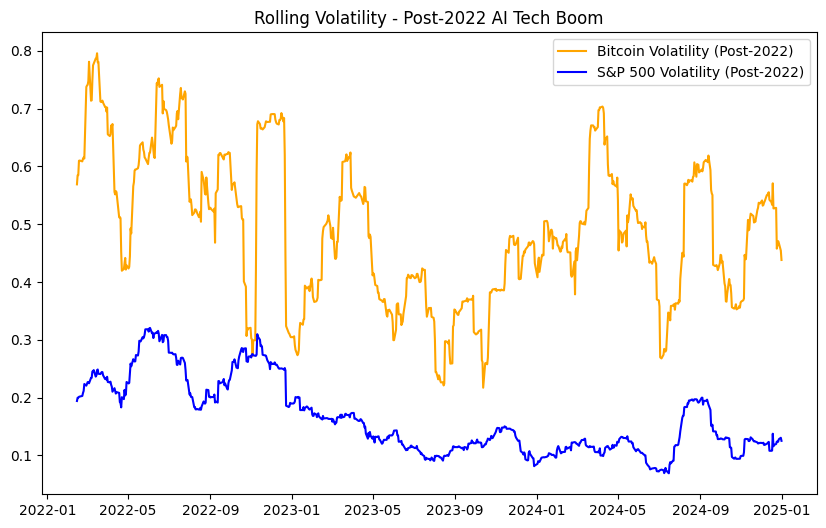

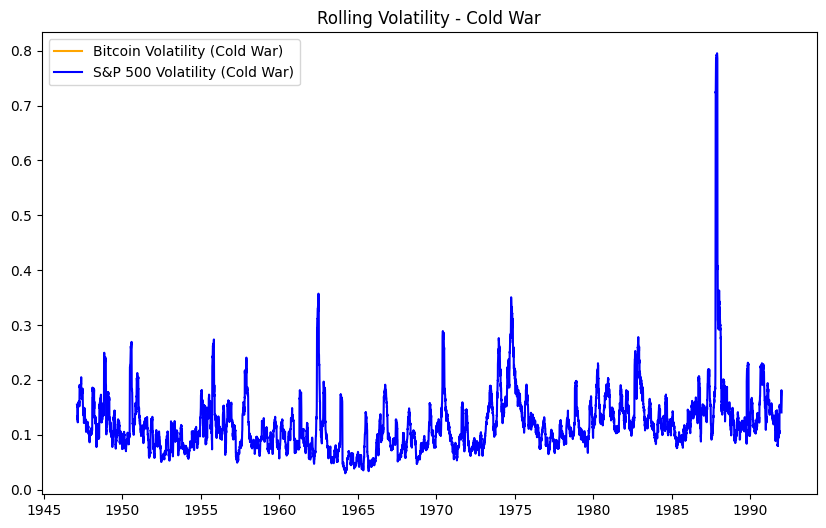

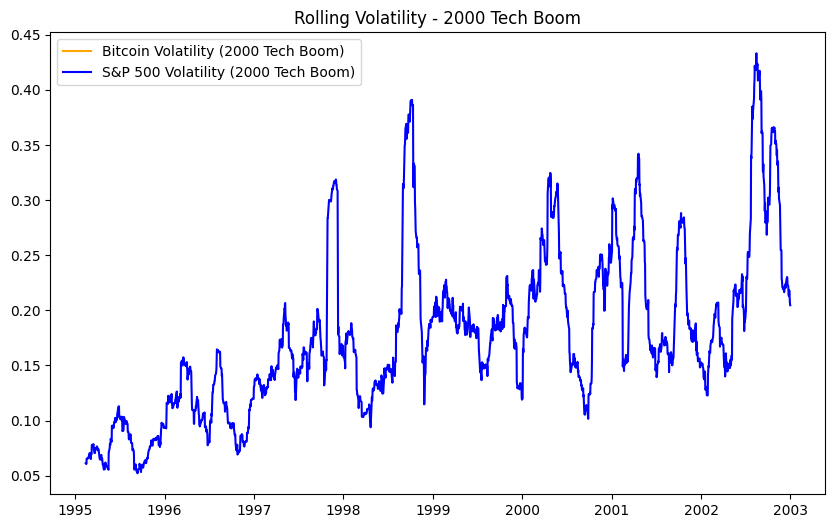

Sharpe Ratio (Post-2022): 0.47774222361867447
Sharpe Ratio (Cold War): nan
Sharpe Ratio (2000 Tech Boom): nan
Max Drawdown (Post-2022): -0.6602200338935257
Max Drawdown (Cold War): nan
Max Drawdown (2000 Tech Boom): nan
Correlation between Bitcoin and S&P 500 (Post-2022): 0.43129345978855144
Correlation between Bitcoin and S&P 500 (Cold War): nan
Correlation between Bitcoin and S&P 500 (2000 Tech Boom): nan


In [3]:
def filter_data_by_period(df, period):
    start_date, end_date = time_periods[period]
    return date_filter(df, start_date, end_date)

# Volatility calculation function
def calculate_rolling_volatility(df, window=30):
    return df.rolling(window=window).std() * np.sqrt(252)  # Annualized volatility

# Sharpe ratio function
def calculate_sharpe_ratio(returns, risk_free_rate=0.01):
    excess_returns = returns - risk_free_rate / 252  # Assume daily risk-free rate
    return np.sqrt(252) * excess_returns.mean() / excess_returns.std()

# Drawdown function
def calculate_drawdowns(returns):
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()  # Return max drawdown

# Correlation function
def calculate_correlation(df, col1, col2):
    return df[col1].corr(df[col2])

# Filter data for different periods
df_yahoo_returns_post_2022 = filter_data_by_period(df_yahoo_returns, "Post-2022 AI Tech Boom")
df_yahoo_returns_cold_war = filter_data_by_period(df_yahoo_returns, "Cold War")
df_yahoo_returns_2000_boom = filter_data_by_period(df_yahoo_returns, "2000 Tech Boom")

# Plot data for comparison
plt.figure(figsize=(10, 6))
plt.plot(df_yahoo_returns_post_2022.index, df_yahoo_returns_post_2022['BTC-USD'], label='Bitcoin Returns (Post-2022)', color='orange')
plt.plot(df_yahoo_returns_post_2022.index, df_yahoo_returns_post_2022['^GSPC'], label='S&P 500 Returns (Post-2022)', color='blue')
plt.axvline(x=pd.Timestamp('2022-01-01'), color='red', linestyle='--', label='Start of AI Tech Boom')
plt.title('Bitcoin and S&P 500 Returns - Post-2022 AI Tech Boom')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(df_yahoo_returns_cold_war.index, df_yahoo_returns_cold_war['BTC-USD'], label='Bitcoin Returns (Cold War)', color='orange')
plt.plot(df_yahoo_returns_cold_war.index, df_yahoo_returns_cold_war['^GSPC'], label='S&P 500 Returns (Cold War)', color='blue')
plt.axvline(x=pd.Timestamp('1947-01-01'), color='red', linestyle='--', label='Start of Cold War')
plt.title('Bitcoin and S&P 500 Returns - Cold War')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(df_yahoo_returns_2000_boom.index, df_yahoo_returns_2000_boom['BTC-USD'], label='Bitcoin Returns (2000 Tech Boom)', color='orange')
plt.plot(df_yahoo_returns_2000_boom.index, df_yahoo_returns_2000_boom['^GSPC'], label='S&P 500 Returns (2000 Tech Boom)', color='blue')
plt.axvline(x=pd.Timestamp('1995-01-01'), color='red', linestyle='--', label='Start of 2000 Tech Boom')
plt.title('Bitcoin and S&P 500 Returns - 2000 Tech Boom')
plt.legend()
plt.show()

# Volatility analysis
volatility_btc_post_2022 = calculate_rolling_volatility(df_yahoo_returns_post_2022['BTC-USD'])
volatility_sp500_post_2022 = calculate_rolling_volatility(df_yahoo_returns_post_2022['^GSPC'])

volatility_btc_cold_war = calculate_rolling_volatility(df_yahoo_returns_cold_war['BTC-USD'])
volatility_sp500_cold_war = calculate_rolling_volatility(df_yahoo_returns_cold_war['^GSPC'])

volatility_btc_2000_boom = calculate_rolling_volatility(df_yahoo_returns_2000_boom['BTC-USD'])
volatility_sp500_2000_boom = calculate_rolling_volatility(df_yahoo_returns_2000_boom['^GSPC'])

# Plot volatility comparisons
plt.figure(figsize=(10, 6))
plt.plot(volatility_btc_post_2022.index, volatility_btc_post_2022, label='Bitcoin Volatility (Post-2022)', color='orange')
plt.plot(volatility_sp500_post_2022.index, volatility_sp500_post_2022, label='S&P 500 Volatility (Post-2022)', color='blue')
plt.title('Rolling Volatility - Post-2022 AI Tech Boom')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(volatility_btc_cold_war.index, volatility_btc_cold_war, label='Bitcoin Volatility (Cold War)', color='orange')
plt.plot(volatility_sp500_cold_war.index, volatility_sp500_cold_war, label='S&P 500 Volatility (Cold War)', color='blue')
plt.title('Rolling Volatility - Cold War')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(volatility_btc_2000_boom.index, volatility_btc_2000_boom, label='Bitcoin Volatility (2000 Tech Boom)', color='orange')
plt.plot(volatility_sp500_2000_boom.index, volatility_sp500_2000_boom, label='S&P 500 Volatility (2000 Tech Boom)', color='blue')
plt.title('Rolling Volatility - 2000 Tech Boom')
plt.legend()
plt.show()

# Scenario Comparisons (Sharpe Ratio, Volatility, Drawdowns)
sharpe_post_2022 = calculate_sharpe_ratio(df_yahoo_returns_post_2022['BTC-USD'])
sharpe_cold_war = calculate_sharpe_ratio(df_yahoo_returns_cold_war['BTC-USD'])
sharpe_2000_boom = calculate_sharpe_ratio(df_yahoo_returns_2000_boom['BTC-USD'])

drawdown_post_2022 = calculate_drawdowns(df_yahoo_returns_post_2022['BTC-USD'])
drawdown_cold_war = calculate_drawdowns(df_yahoo_returns_cold_war['BTC-USD'])
drawdown_2000_boom = calculate_drawdowns(df_yahoo_returns_2000_boom['BTC-USD'])

# Output Sharpe ratio and max drawdown results
print(f"Sharpe Ratio (Post-2022): {sharpe_post_2022}")
print(f"Sharpe Ratio (Cold War): {sharpe_cold_war}")
print(f"Sharpe Ratio (2000 Tech Boom): {sharpe_2000_boom}")

print(f"Max Drawdown (Post-2022): {drawdown_post_2022}")
print(f"Max Drawdown (Cold War): {drawdown_cold_war}")
print(f"Max Drawdown (2000 Tech Boom): {drawdown_2000_boom}")

# Correlation analysis
correlation_post_2022 = calculate_correlation(df_yahoo_returns_post_2022, 'BTC-USD', '^GSPC')
correlation_cold_war = calculate_correlation(df_yahoo_returns_cold_war, 'BTC-USD', '^GSPC')
correlation_2000_boom = calculate_correlation(df_yahoo_returns_2000_boom, 'BTC-USD', '^GSPC')

print(f"Correlation between Bitcoin and S&P 500 (Post-2022): {correlation_post_2022}")
print(f"Correlation between Bitcoin and S&P 500 (Cold War): {correlation_cold_war}")
print(f"Correlation between Bitcoin and S&P 500 (2000 Tech Boom): {correlation_2000_boom}")
